#   Satellite Image Classification | CNN | Fine Tuning NasNet Mobile - %95 Accuracy

The "Satellite Image Classification" dataset on Kaggle is a collection of satellite images labeled with classes such as "Cloudy", "Desert", "Green_Area", and "Water". The data is made up of satellite images of size 256x256, and can be used for computer vision tasks such as image classification.


# Importing Libraries

In [1]:
import keras
import tensorflow as tf
print("Keras Current Version:", keras.__version__, "Tensorflow Current Version:", tf.__version__)

Keras Current Version: 3.4.1 Tensorflow Current Version: 2.17.0


In [2]:
from glob import glob
import random, os, datetime

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, metrics
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models  import Sequential, load_model
from tensorflow.keras.metrics import Accuracy, AUC

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
def get_image_paths(root_dir, num_images=None):
    all_images = []
    for extension in ['*.jpg', '*.jpeg', '*.png']:
        all_images.extend(glob(os.path.join(root_dir, '**', extension), recursive=True))
    if num_images is None:
        return all_images
    else:
        return random.sample(all_images, min(num_images, len(all_images)))


def display_images(img_list):
    plt.figure(figsize=(15, 6))
    for i, img_path in enumerate(img_list):
        img = image.load_img(img_path)
        img = image.img_to_array(img, dtype=np.uint8)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img.squeeze())
        plt.axis('off')
        plt.title(f'Image {i+1}')
    plt.tight_layout()
    plt.show()


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dir_path = '/content/drive/MyDrive/Colab Notebooks/satellite_data'

In [6]:
img_list = get_image_paths(dir_path)

print(len(img_list))

5631


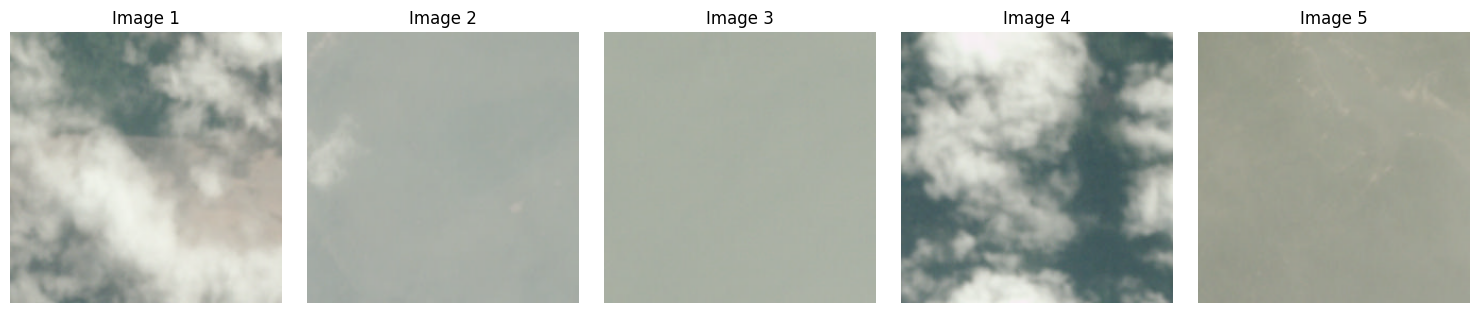

In [7]:
display_images(img_list[0:5])

# Train / Validation Sets

In [8]:
train = ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255,
                         shear_range = 0.1,
                         zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)

val = ImageDataGenerator(rescale=1/255,
                        validation_split=0.1)


In [9]:
train_generator=train.flow_from_directory(dir_path,
                                          target_size=(224, 224),
                                          batch_size=32,
                                          class_mode='categorical',
                                          subset='training')

validation_generator=val.flow_from_directory(dir_path,
                                        target_size=(224, 224),
                                        batch_size=563,
                                        class_mode='categorical',
                                        subset='validation')

Found 5068 images belonging to 4 classes.
Found 563 images belonging to 4 classes.


# Creating Models

In [10]:
from tensorflow.keras import layers, models, optimizers

# Modeli tanımla
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),  # Ekstra Convolutional Katman
    layers.GlobalAveragePooling2D(),  # Flatten yerine Global Average Pooling
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),  # Dropout oranını artırdık
    layers.Dense(4, activation='softmax'),
])

# Optimize edici, kayıp fonksiyonu ve metrikler
metrics = [
    "accuracy",
    AUC(name='auc', multi_label=True)
]

# Daha düşük bir öğrenme oranı ile optimize edici
optimizer = optimizers.Adam(learning_rate=0.0001)  # Öğrenme oranını düşürdük

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=metrics)

# Erken durdurma ve model kontrol noktası
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=15,  # Sabırlılık süresini artırdık
                               verbose=1,
                               restore_best_weights=True)

model_checkpoint = ModelCheckpoint(filepath='satellite.keras',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   save_weights_only=False,
                                   verbose=1)


In [11]:
start_time = datetime.datetime.now()

history = model.fit(train_generator,
                    epochs=30,
                    validation_data=validation_generator,
                    callbacks=[early_stopping, model_checkpoint])

end_time = datetime.datetime.now()
total_duration = end_time - start_time
print("Trainin Time:", total_duration)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.3882 - auc: 0.7794 - loss: 1.1723 
Epoch 1: val_loss improved from inf to 0.51716, saving model to satellite.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 2604s 16s/step - accuracy: 0.3892 - auc: 0.7800 - loss: 1.1706 - val_accuracy: 0.6856 - val_auc: 0.9528 - val_loss: 0.5172
Epoch 2/30
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.7027 - auc: 0.9110 - loss: 0.5417
Epoch 2: val_loss improved from 0.51716 to 0.47594, saving model to satellite.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 69s 416ms/step - accuracy: 0.7028 - auc: 0.9111 - loss: 0.5415 - val_accuracy: 0.8668 - val_auc: 0.9590 - val_loss: 0.4759
Epoch 3/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.7491 - auc: 0.9323 - loss: 0.4837
Epoch 3: val_loss did not improve from 0.47594
159/159 ━━━━━━━━━━━━━━━━━━━━ 69s 414ms/step - accuracy: 0.7492 - auc: 0.9324 - loss: 0.4837 - val_accuracy: 0.7798 - val_auc: 0.9602 - val_loss: 0.4777
Epoch 4/30
159/159 ━━━━━━━━━━━━━━━━━━━━

# Model Performance

In [12]:
val_loss, val_accuracy, val_auc = model.evaluate(validation_generator, verbose=0)
print(f"Loss: {val_loss}")
print(f"Accuracy: {val_accuracy}")
print(f"AUC: {val_auc}")

Loss: 0.29379406571388245
Accuracy: 0.8952042460441589
AUC: 0.979681670665741


In [13]:
def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()

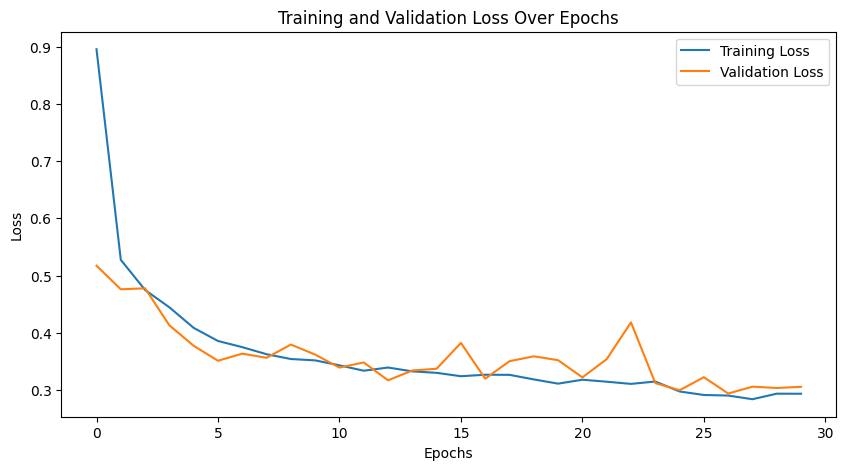

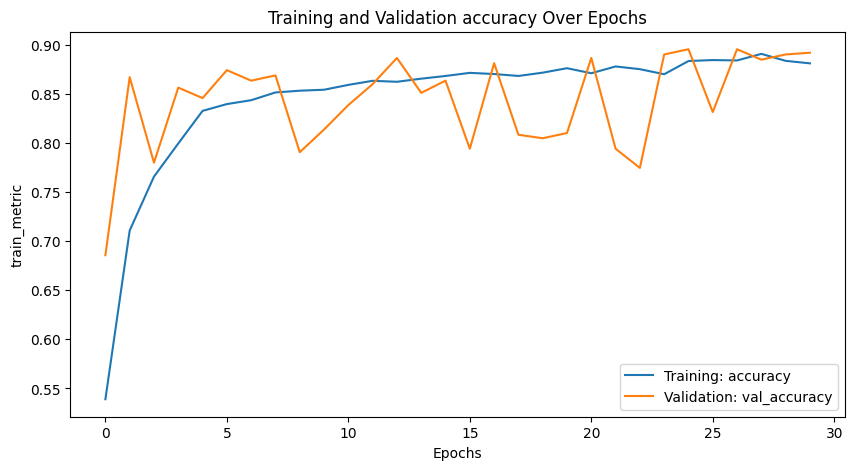

In [14]:
plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy')

# Fine Tuning with NASNetMobile

In [16]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.nasnet import NASNetMobile, preprocess_input as preprocess_input_nasnet

In [17]:
base_model = NASNetMobile(weights='imagenet',
                            include_top=False,
                            input_shape=(224, 224, 3))

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [19]:
base_model.summary()

Model: "nasnet_mobile"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv1 (Conv2D)       │ (None, 111, 111, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn1                  │ (None, 111, 111, 32)   │            128 │ stem_conv1[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_conv_1_stem_1   │ (None, 111, 111, 11)   │            352 │ activation[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_bn_1_stem_1     │ (None, 111, 111, 11)   │             44 │ reduction_conv_1_stem… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 111, 111, 11)   │              0 │ reduction_bn_1_stem_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 111, 111, 32)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 115, 115, 11)   │              0 │ activation_1[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 117, 117, 32)   │              0 │ activation_3[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 56, 56, 11)     │            396 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 56, 56, 11)     │          1,920 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 56, 56, 11)     │             44 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 56, 56, 11)     │             44 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activat

 Total params: 4,269,716 (16.29 MB)

 Trainable params: 4,232,978 (16.15 MB)

 Non-trainable params: 36,738 (143.51 KB)

In [20]:
for layer in base_model.layers:
    layer.trainable = False

In [21]:
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [23]:
x = GlobalAveragePooling2D()(base_model.output)

x = Dense(4, activation='softmax')(x)

fine_tuning_model = Model(inputs=base_model.input, outputs=x)

In [24]:
optimizer=SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)

fine_tuning_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])

In [25]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True,
                               verbose=1)


model_checkpoint = ModelCheckpoint('NASNetMobile_finetuned.keras',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   save_weights_only=False,
                                   verbose=1)

In [26]:
start_time = datetime.datetime.now()

fine_tuning_model_history = fine_tuning_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

end_time = datetime.datetime.now()

total_duration = end_time - start_time
print("Training Time:", total_duration)

Epoch 1/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.2933 - loss: 1.3880
Epoch 1: val_loss improved from inf to 1.11516, saving model to NASNetMobile_finetuned.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 177s 863ms/step - accuracy: 0.2940 - loss: 1.3873 - val_accuracy: 0.5275 - val_loss: 1.1152
Epoch 2/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.6654 - loss: 1.0277
Epoch 2: val_loss improved from 1.11516 to 0.92737, saving model to NASNetMobile_finetuned.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 73s 440ms/step - accuracy: 0.6658 - loss: 1.0273 - val_accuracy: 0.7496 - val_loss: 0.9274
Epoch 3/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.8270 - loss: 0.8496
Epoch 3: val_loss improved from 0.92737 to 0.80881, saving model to NASNetMobile_finetuned.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 73s 441ms/step - accuracy: 0.8270 - loss: 0.8494 - val_accuracy: 0.7584 - val_loss: 0.8088
Epoch 4/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.8567 - loss: 0.7152


In [31]:
val_loss, val_accuracy = fine_tuning_model.evaluate(validation_generator, verbose=0)
print(f"Loss: {val_loss}")
print(f"Accuracy: {val_accuracy}")

Loss: 0.24222023785114288
Accuracy: 0.950266420841217


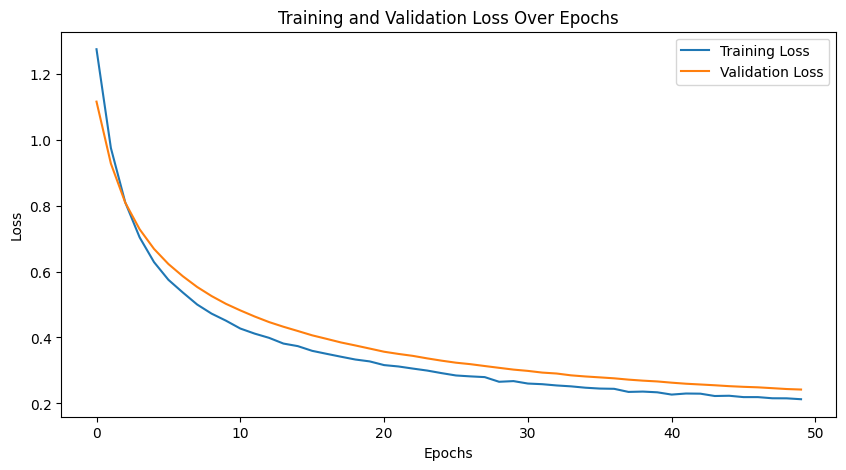

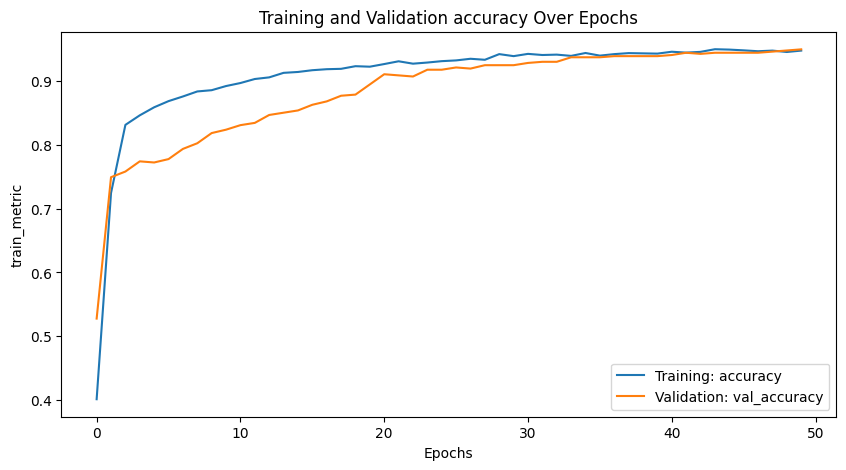

In [32]:
plot_training_history(fine_tuning_model_history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy')